In [1]:
%load_ext autoreload
%autoreload 2

# PRFM cookbook

In [205]:
from prfm import *

In [190]:
# default parameters
Sigma_gas = 10*ac.M_sun/ac.pc**2
Sigma_star = 42*ac.M_sun/ac.pc**2 
Omega_d = 28*au.km/au.s/ac.kpc
H_star = 245*ac.pc

R = np.linspace(2,16,50)*ac.kpc
R0 = 8*ac.kpc
Re = 3.5*ac.kpc

# in cgs
Sigma_gas = Sigma_gas.cgs.value
Sigma_star = Sigma_star.cgs.value
Omega_d = Omega_d.cgs.value
H_star = H_star.cgs.value
r0 = (R/R0).cgs.value
re = (R/Re).cgs.value

# to array
Sigma_gas = Sigma_gas/r0 # linear in R
Sigma_star = Sigma_star*np.exp((R0/Re).cgs.value-re)
Omega_d = Omega_d/r0 # flat rotation
H_star = H_star # no flaring
args = (Sigma_gas, Sigma_star, Omega_d, H_star)

# default keywords
kwargs = dict(sigma_eff=15.e5,
              zeta_d=1/3.)

In [191]:
import matplotlib.pyplot as plt

In [192]:
labels = ['gas', 'star', 'dm']

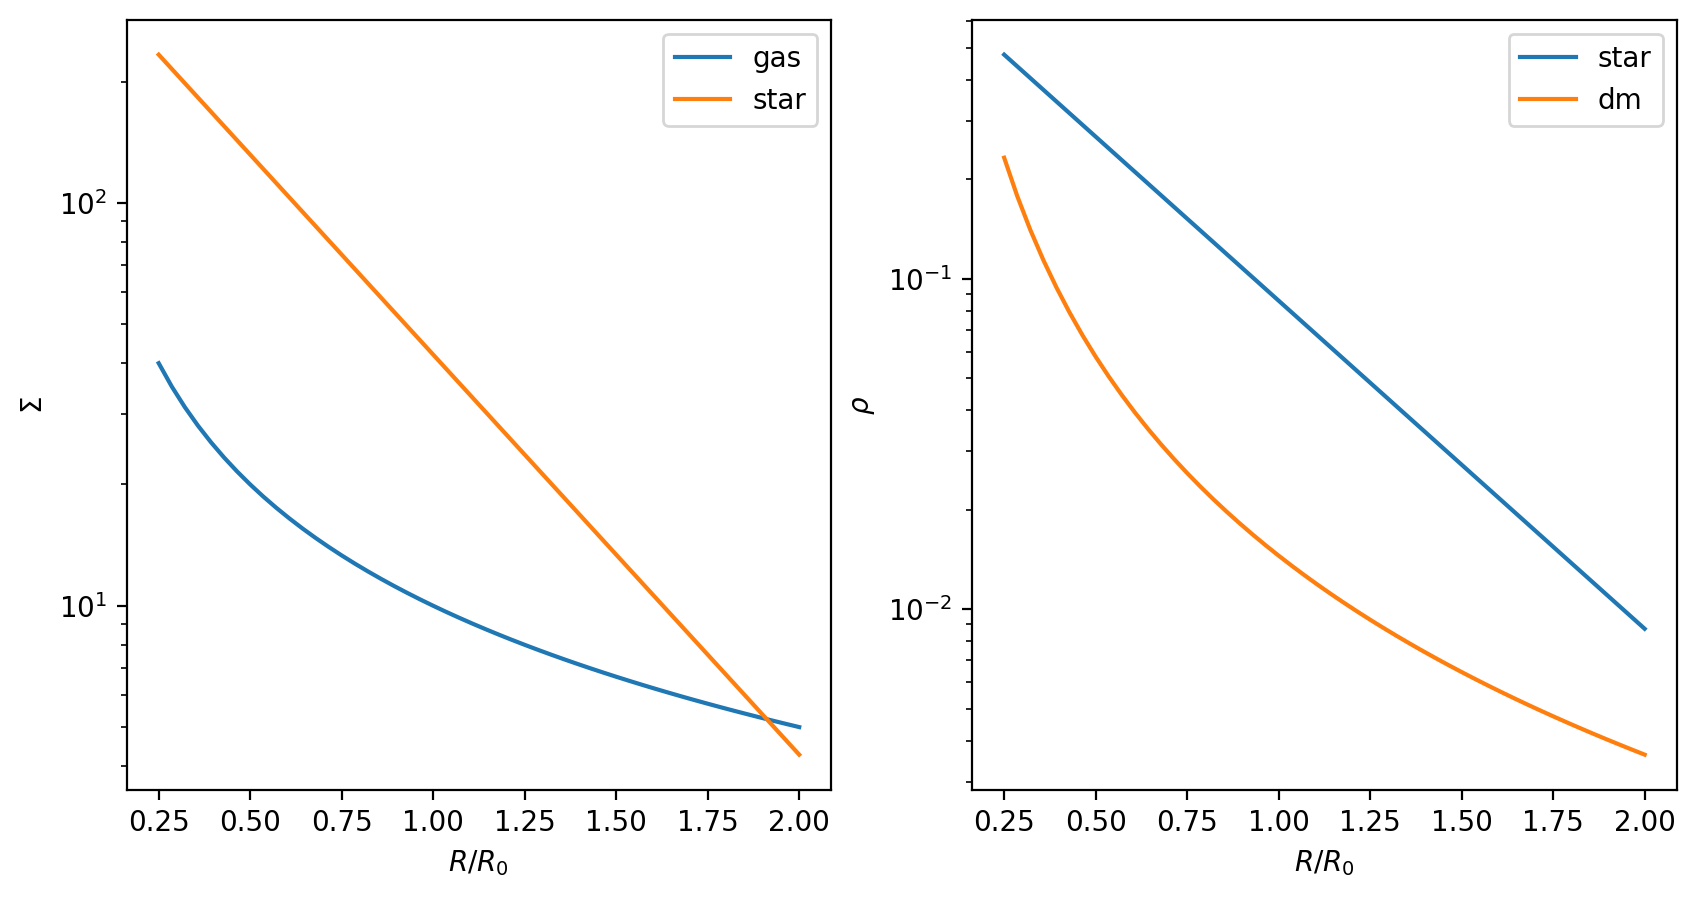

In [194]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(r0, Sigma_gas/surf_cgs,label='gas')
plt.plot(r0, Sigma_star/surf_cgs,label='star')
plt.ylabel(r'$\Sigma$')
plt.xlabel(r'$R/R_0$')
plt.legend()
plt.yscale('log')

plt.subplot(122)
plt.plot(r0, Sigma_star/surf_cgs/(2*H_star/pc_cgs),label='star')
plt.plot(r0, (Omega_d**2/4/np.pi/Gconst_cgs)/surf_cgs*pc_cgs,label='dm')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$R/R_0$')
plt.legend()
plt.yscale('log')


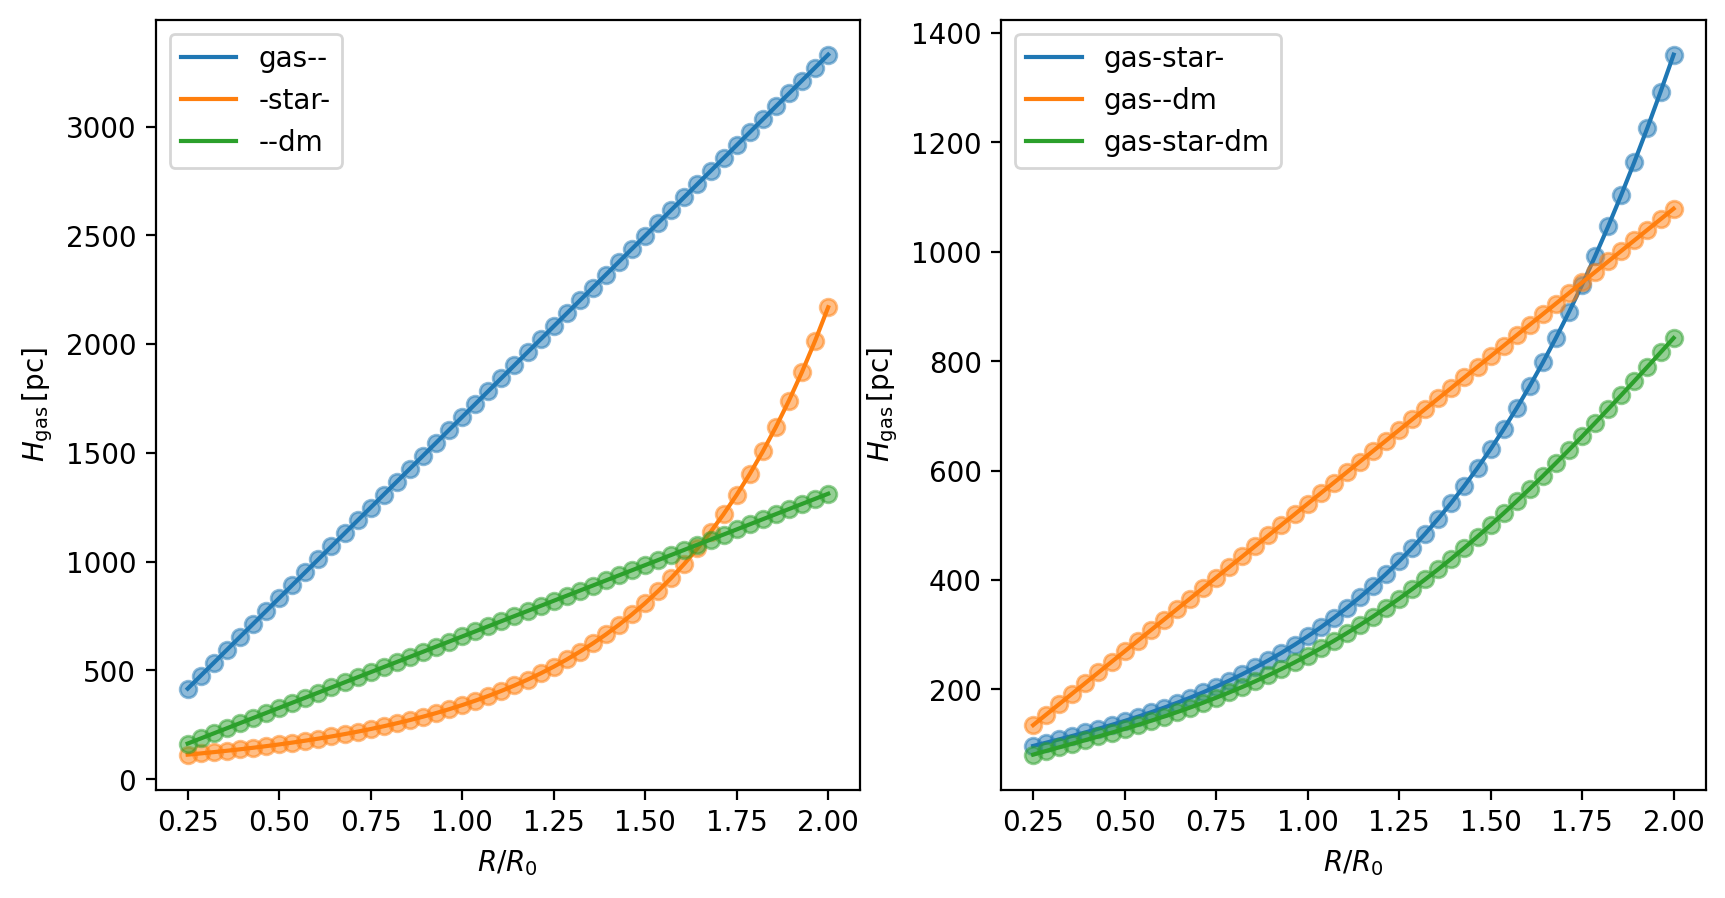

In [195]:
plt.rcParams['figure.dpi']=200
# sanity checks
fig, axes = plt.subplots(1,2, figsize=(10,5))

labels = ['gas', 'star', 'dm']
# gas, star, dm only scale heights
plt.sca(axes[0])
for func, w in zip([get_scale_height_gas_only,
                    get_scale_height_star_only,
                    get_scale_height_dm_only], 
                    [[1,0,0],[0,1,0],[0,0,1]]):
  H_ana = func(*args,**kwargs)
  H_num = func(*args,**kwargs,wgas=w[0],wstar=w[1],wdm=w[2])
  label = '-'.join([l if w_==1 else '' for w_,l in zip(w,labels)])
  l,=plt.plot(r0,H_ana/pc_cgs,label = label)
  plt.plot(r0,H_num/pc_cgs,'o',color=l.get_color(),alpha=0.5)
plt.ylabel(r'$H_{\rm gas}\,[{\rm pc}]$')
plt.xlabel(r'$R/R_0$')
plt.legend()
# star-gas, dm-gas, and full scale heights
plt.sca(axes[1])
for func, w in zip([get_scale_height_star_gas,
                    get_scale_height_dm_gas,
                    get_scale_height], 
                    [[1,1,0],[1,0,1],[1,1,1]]):
  H_ana = func(*args,**kwargs)
  H_num = func(*args,**kwargs,wgas=w[0],wstar=w[1],wdm=w[2])
  label = '-'.join([l if w_==1 else '' for w_,l in zip(w,labels)])

  l,=plt.plot(r0,H_ana/pc_cgs, label = label)
  plt.plot(r0,H_num/pc_cgs,'o',color=l.get_color(),alpha=0.5)
plt.ylabel(r'$H_{\rm gas}\,[{\rm pc}]$')
plt.xlabel(r'$R/R_0$')
plt.legend()


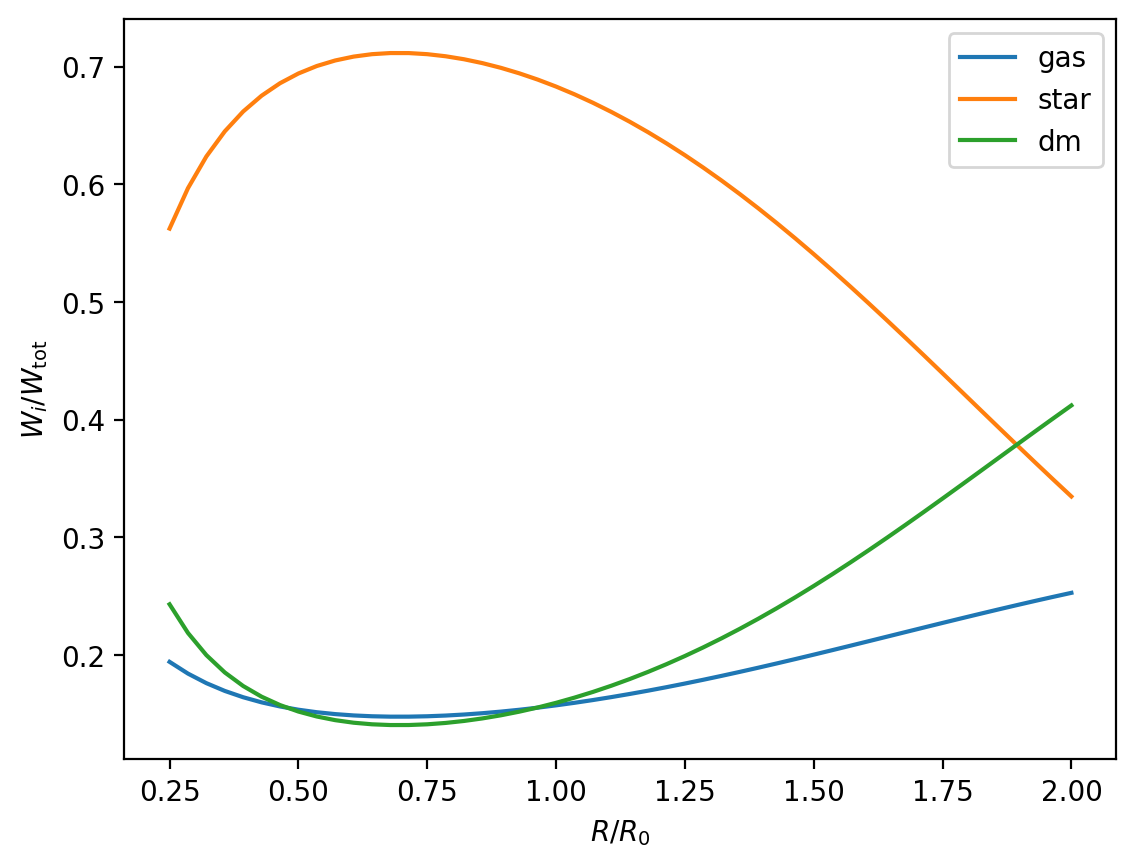

In [196]:
wfrac=get_weight_contribution(*args,**kwargs)
plt.plot(r0,wfrac[0],label='gas')
plt.plot(r0,wfrac[1],label='star')
plt.plot(r0,wfrac[2],label='dm')
plt.ylabel(r'$W_i/W_{\rm tot}$')
plt.xlabel(r'$R/R_0$')
plt.legend()


In [197]:
from prfm import *

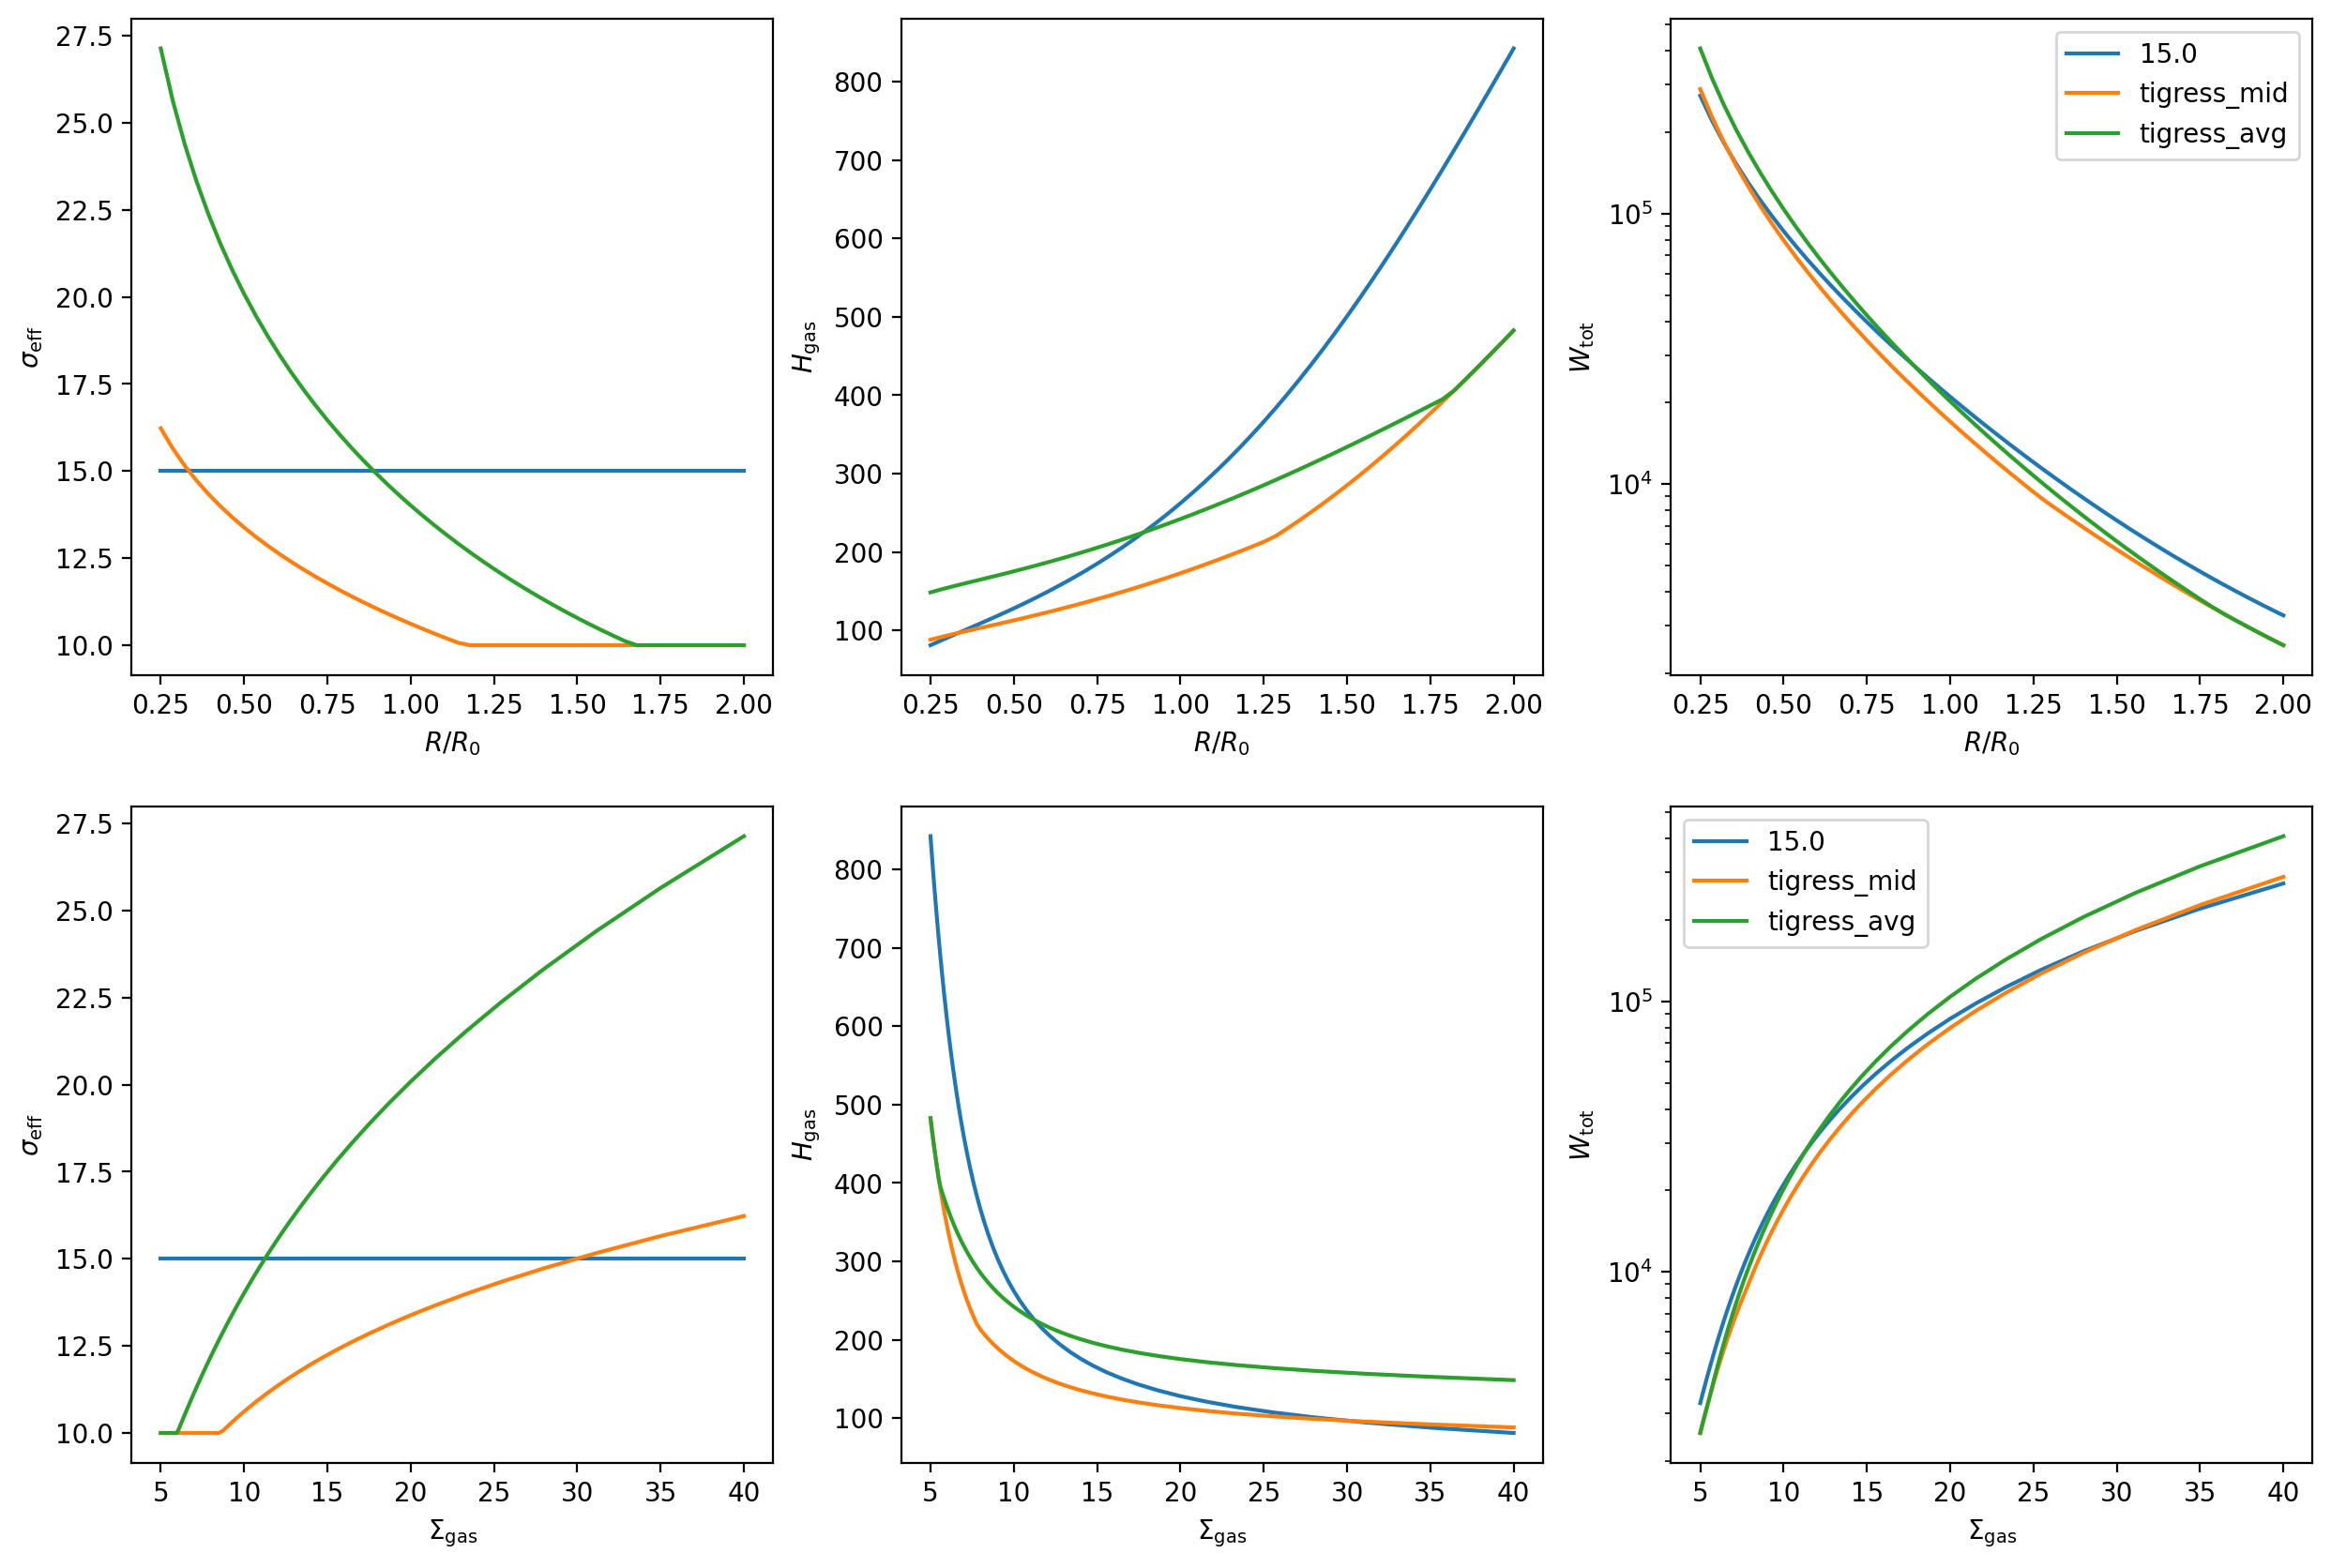

In [202]:
fig,axes_ = plt.subplots(2, 3, figsize=(15,10))
axes = axes_[0,:]
for sigma in [15.e5, 'tigress_mid', 'tigress_avg']:
    Wtot, H, seff = get_self_consistent_solution(*args,sigma_eff=sigma)
    label='{}'.format(sigma if type(sigma) == str else sigma/1.e5)
    for y,ax in zip([seff/kms_cgs, H/pc_cgs, Wtot/kbol_cgs],axes):
        plt.sca(ax)
        plt.plot(r0, y, label=label)
xlab = r'$R/R_0$'
ylabels = [r'$\sigma_{\rm eff}$', r'$H_{\rm gas}$', r'$W_{\rm tot}$']
for ax, ylab in zip(axes,ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale('log')
# plt.xscale('log')
plt.legend()

axes = axes_[1,:]
for sigma in [15.e5, 'tigress_mid', 'tigress_avg']:
    Wtot, H, seff = get_self_consistent_solution(*args,sigma_eff=sigma)
    label='{}'.format(sigma if type(sigma) == str else sigma/1.e5)
    for y,ax in zip([seff/kms_cgs, H/pc_cgs, Wtot/kbol_cgs],axes):
        plt.sca(ax)
        plt.plot(Sigma_gas/surf_cgs, y, label=label)
xlab = r'$\Sigma_{\rm gas}$'
ylabels = [r'$\sigma_{\rm eff}$', r'$H_{\rm gas}$', r'$W_{\rm tot}$']
for ax, ylab in zip(axes,ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale('log')
# plt.xscale('log')
plt.legend()
